In [1]:
import os
import numpy as np
from netCDF4 import Dataset
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from shapely.geometry import mapping
import xarray as xr

In [2]:

data_dir = '../results/gcomc/sst/'
shapefile_path = 'trend/SB_Big_shapefiles/Untitled-polygon.shp'
varname = 'sst'
cmin, cmax = 12, 30  # Set the min and max values for the color scale
# Initialize a dictionary to hold the data for each month.
monthly_data = {month: [] for month in range(1, 13)}
yearly_data = {month: [] for month in range(2002, 2024)}
season_data  = {"winter": [], "spring": [], "summar": [],"autumn": []}
all_data = {"all": []}
print(monthly_data)
# Assuming these are the coordinates you want to crop to
# lat_min_crop, lat_max_crop = 34.3, 35.7  # Update these values as needed
# lon_min_crop, lon_max_crop = 138.3, 140.23  # Update these values as needed

lat_min_crop, lat_max_crop = 34.5, 35.4
lon_min_crop, lon_max_crop = 138.9, 139.9
# lat_min_crop, lat_max_crop = 34.4, 35.7
# lon_min_crop, lon_max_crop = 138.35, 140.2
# rectangle_coords = [(35.7,  138.35), (35.7, 140.2), (34.4, 140.2), (34.4,  138.35), (35.7,  138.35)]



{1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: []}


In [3]:

# Loop through files and accumulate data
for fol in os.listdir(data_dir):
#     # Loop through files and accumulate data
    for file_name in os.listdir(data_dir + fol):
        
        if file_name.endswith('.nc'):
            # year, month = int(file_name[1:5]), int(file_name[5:7])  # Modis
            year, month = int(file_name[2:6]), int(file_name[6:8])   # GCOMC
            
            if year < 2003 or year > 2022:
                continue
            
            file_path = os.path.join(data_dir+fol, file_name)
            
            # crop  the data to the region of interest with shapefile
            shapefile = gpd.read_file(shapefile_path)
            shapefile = shapefile.to_crs("EPSG:4326")
                    
            ds = xr.open_dataset(file_path)
            ds = ds.rio.write_crs("epsg:4326")  # Assuming your netCDF data is in WGS 84; change this as necessary
            # Get the bounding box of the shapefile
            cropped_ds = ds.rio.clip(shapefile.geometry.apply(mapping), shapefile.crs, drop=True)
            # lets take 500m buffer around the shapefile to exclude the data from the buffer
            # cropped_ds = ds.rio.clip(shapefile.geometry.apply(lambda x: x.buffer(-0.05)), shapefile.crs, drop=True)
            # cropped_ds = ds.rio.clip(shapefile.geometry.buffer(1).apply(mapping), shapefile.crs, drop=True)
            # cropped_ds = ds.rio.clip(shapefile.geometry.buffer(-0.5).apply(mapping), shapefile.crs, drop=True)
            
            # # Assuming 'shapefile' is a GeoDataFrame
            # geometries = shapefile.geometry.buffer(-0.05)  # Adjust the buffer value as needed
            # # print(geometries)
            # # Check if any geometries are empty or invalid
            # invalid_geometries = geometries.is_empty | ~geometries.is_valid

            # if invalid_geometries.any():
            #     print("Warning: Invalid or empty geometries found. Consider adjusting the buffer value or correcting the geometries.")

            # # Convert geometries to the correct format
            # geometries = geometries.apply(mapping)

            # # Now try to clip with the validated and correctly formatted geometries
            # try:
            #     cropped_ds = ds.rio.clip(
            #         geometries[~invalid_geometries],  # Exclude invalid geometries
            #         crs=shapefile.crs,
            #         drop=True
            #     )
            # except ValueError as e:
            #     print(f"Error: {e}")


            lat = cropped_ds['lat'].values
            lon = cropped_ds['lon'].values
            sst = cropped_ds[varname].values
            # print(sst)
            data = np.squeeze(sst)

            with Dataset(file_path, 'r') as nc:
                # da = nc[varname][:]
                # # mask
                # data = np.ma.squeeze(da)

                # lat = nc['lat'][:]
                # lon = nc['lon'][:]
                # Find indices for cropping
                lat_inds = np.where((lat >= lat_min_crop) & (lat <= lat_max_crop))[0]
                lon_inds = np.where((lon >= lon_min_crop) & (lon <= lon_max_crop))[0]
                # Crop data
                # Now add a check to ensure the indices are within the bounds of the array
                if lat_inds.size > 0 and lon_inds.size > 0: # Adjust the slicing based on the actual dimensions of sds
                    data_cropped = data[lat_inds, :][:, lon_inds]  # This is the updated line for a 2D array
                    lat_cropped = lat[lat_inds]
                    lon_cropped = lon[lon_inds]
                else:
                    print("No data within specified crop bounds.")
                
                # print(np.ma.mean(data_cropped))    
                # sds_cropped = sds[:, lat_inds, :][:, :, lon_inds]  # Assuming sds has a shape of [time, lat, lon]
                lat_cropped = lat[lat_inds]
                lon_cropped = lon[lon_inds]
                
                # Convert masked values to NaN
                # data_cropped = np.where(data_cropped.mask, np.nan, data_cropped)
                
                # mask = np.where(~sds_cropped.mask, np.nan, 0)
                
                yearly_data[year].append(data_cropped)
                monthly_data[month].append(data_cropped)
                all_data["all"].append(data_cropped)

                if month in [12,1,2]:
                    season_data["winter"].append(data_cropped)
                elif month in [3,4,5]:
                    season_data["spring"].append(data_cropped)                
                elif month in [6,7,8]:
                    season_data["summar"].append(data_cropped)    
                else: # 9 10 11
                    season_data["autumn"].append(data_cropped)    
                    
                    
print(len(yearly_data))            

22


In [4]:

from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plot, colors

hex_colors_sst = [
    '#FF2700',  # Red
    '#FFA500',  # Orange
    '#FDFF92',  # Yellow
    '#b7f0ae',  # Light Green
    '#21f600',  # Bright Green
    '#0000FF',  # Blue
    '#4b0082',  # Indigo
    '#d600ff',  # Purple (Violet)
    '#a500ff',  # Deep Purple (darker Violet)
    '#ffffff'  # White (for peak temperatures)
]
hex_colors_chl = [
    '#3500a8',  '#5C5CFF','#005EFF','#00FFFF',
     '#097969','#50C878',"#4CBB17",'#77f800','#DFFF00','yellow', "#FFBF00", "red",
    '#b30000', '#990000'
]
# hex_colors_chl = [
#     '#000075',  # Dark Purple (Very Cold)
#     '#0000A3',  # Light Blue (Cold)
#     '#0000D1',  # Sky Blue (Cool)
#     '#0000FF',  # Cyan (Moderate)
#     '#2E2EFF',  # Cyan (Moderate)
#     '#5C5CFF',  # Cyan (Moderate)
#     '#8A8AFF',  # Cyan (Moderate)

#     "#007500",
#     "#00A300",
#     "#00D100",
#     "#00FF00",
#     "#5CFF5C",
#     "#8AFF8A",
 
#     "#757500",
#     "#A3A300",
#     "#D1D100",
#     "#FFFF00",
#     "#FFFF5C",

#     "#FF8A8A",
#     "#FF5C5C",
#     "#FF2E2E",
#     "#FF0000",
#     "#D10000",
#     "#A30000",
#     "#FF8A8A",

# ]

# # Convert hex color list to RGB
rgb_colors = [colors.hex2color(color) for color in hex_colors_chl]
# rgb_colors = ["blue", "#008080","green","#28B463", "yellow","orange","#FA8072","red","#811331"]
# rgb_colors = ["blue","#4169e1","lightgreen","green","#75E6DA", "yellow", "orange", "#f88379", "red"]


# rgb_colors = ["#4169e1","lightgreen","green","#75E6DA", "yellow", "orange", "#f88379", "red"]
# rgb_colors = [ "green",  "yellow","red"]
# rgb_colors = [
#     "green", "lightgreen", "limegreen", "yellowgreen", "yellow",
#     "gold", "orange", "coral", "darkorange","purple", "magenta", "fuchsia", "red",
#     "darkred", "maroon"
# ]
print(monthly_data)
monthly_averages = {month: np.nanmean(np.stack(data_list), axis=0) for month, data_list in monthly_data.items() if data_list}
yearly_averages = {year: np.nanmean(np.stack(data_list), axis=0) for year, data_list in yearly_data.items() if data_list}
season_averages = {season: np.nanmean(np.stack(data_list), axis=0) for season, data_list in season_data.items() if data_list}
all_average = {str: np.nanmean(np.stack(data_list), axis=0) for str, data_list in all_data.items() if data_list}


{1: [array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [18.77    , 18.734999, 18.73    , ...,       nan,       nan,
              nan],
       [18.8     , 18.779999, 18.755   , ...,       nan,       nan,
              nan],
       [18.779999, 18.785   , 18.77    , ...,       nan,       nan,
              nan]], dtype=float32), array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [18.545   , 18.535   , 18.529999, ...,       nan,       nan,
              nan],
       [18.535   , 18.55    , 18.57    , ...,       nan,       nan,
      

C:\Users\Robel\AppData\Local\Temp\ipykernel_28284\1986228225.py:67: RuntimeWarning: Mean of empty slice
  monthly_averages = {month: np.nanmean(np.stack(data_list), axis=0) for month, data_list in monthly_data.items() if data_list}
C:\Users\Robel\AppData\Local\Temp\ipykernel_28284\1986228225.py:68: RuntimeWarning: Mean of empty slice
  yearly_averages = {year: np.nanmean(np.stack(data_list), axis=0) for year, data_list in yearly_data.items() if data_list}
C:\Users\Robel\AppData\Local\Temp\ipykernel_28284\1986228225.py:69: RuntimeWarning: Mean of empty slice
  season_averages = {season: np.nanmean(np.stack(data_list), axis=0) for season, data_list in season_data.items() if data_list}
C:\Users\Robel\AppData\Local\Temp\ipykernel_28284\1986228225.py:70: RuntimeWarning: Mean of empty slice
  all_average = {str: np.nanmean(np.stack(data_list), axis=0) for str, data_list in all_data.items() if data_list}


In [5]:
print(len(monthly_averages))


12


12
1
runnign nan nan all


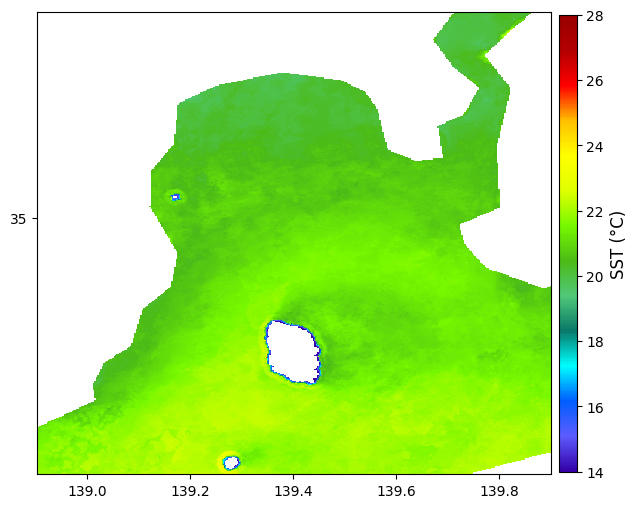

In [5]:
# cmin, cmax = -2,2
cmin, cmax = 14, 28
print(len(monthly_averages))
print(len(all_average))


for season, sds_cropped in all_average.items():
    # if season == "winter":
    #     cmin, cmax = 15, 19
    # elif season == "spring":
    #     cmin, cmax = 15, 18
    # elif season == "summar":
    #     cmin, cmax = 23, 26
    # else: # autumn
    #     cmin, cmax = 20, 25
    print("runnign", sds_cropped.min(), sds_cropped.max(),season)
    if len(lon_cropped.shape) == 1:
        lon_cropped, lat_cropped = np.meshgrid(lon_cropped, lat_cropped)
    
    lon_0, lat_0 = (lon_cropped.min() + lon_cropped.max()), (lat_cropped.min() + lat_cropped.max()) / 2
    m = Basemap(llcrnrlon=lon_cropped.min(), llcrnrlat=lat_cropped.min(), 
                        urcrnrlon=lon_cropped.max(), urcrnrlat=lat_cropped.max(), resolution='i', 
                        lon_0=lon_0, lat_0=lat_0, projection='merc')

    # Adjust figsize to change the aspect ratio
    fig, ax = plot.subplots(figsize=(7, 6))  # Adjust the width and height to better suit your data aspect ratio
    
    # land and water contours
    # m.drawcoastlines()
    # m.drawcountries()
    # m.drawrivers()
    # m.drawmapboundary(fill_color='gray')
    # m.fillcontinents(color='lightgray', lake_color='gray')
    # m.drawparallels(np.arange(lat_cropped.min(), lat_cropped.max(), 0.2), labels=[1, 0, 0, 0])
    # m.drawmeridians(np.arange(lon_cropped.min(), lon_cropped.max(), 0.2), labels=[0, 0, 0, 1])

    # m.pcolormesh(lon_cropped, lat_cropped, sds_cropped, latlon=True, cmap=custom_colormap, vmin=cmin, vmax=cmax)
    # Create a mask for the data outside the contour range
    # data_mask = (sds_cropped < cmin) | (sds_cropped > cmax)

    # # Apply the mask to your data
    # sds_cropped_masked = np.ma.masked_where(data_mask, sds_cropped)

    # # Continue with your existing plotting code, but use the masked data
    # m.pcolormesh(lon_cropped, lat_cropped, sds_cropped_masked, latlon=True, cmap='jet', vmin=cmin, vmax=cmax)


    # figure bounds
    extent = [lon_cropped.min(), lon_cropped.max(), lat_cropped.min(), lat_cropped.max()]

    # Land mask
    # mask = np.where(~sds_cropped.mask, np.nan, 0)
    # mask 0 values with nan
    #  sds_cropped = np.where(sds_cropped ==0.0, np.nan, sds_cropped)
    ax.imshow(sds_cropped, cmap='gray', vmin=cmin, vmax=cmax, extent=extent)
    # ax.imshow(sds_cropped, cmap='gray', vmin=cmin, vmax=cmax, extent=extent)

    # Create a colormap object
    custom_colormap = LinearSegmentedColormap.from_list('custom', rgb_colors)

    # print(sds_cropped_log.max(), sds_cropped_log.min())

    # We no longer use LogNorm here since we've manually applied log10
    # ims = ax.imshow(sds_cropped_log, cmap='jet', extent=extent)
    # ims = ax.imshow(sds_cropped,vmin=cmin, vmax=cmax,   extent=extent)

    ims = ax.imshow(sds_cropped,vmin=cmin, vmax=cmax, cmap=custom_colormap, extent=extent)
     
    # # Figure labels
    # ax.set_xlabel('Longitude [$^\mathregular{o}$E]', fontsize="12")
    # ax.set_ylabel('Latitude [$^\mathregular{o}$N]', fontsize="12")
    ax.set_yticks(range(int(np.ceil(lat_cropped.min())), int(np.ceil(lat_cropped.max())), 1))
    # ax.set_title(time[0].strftime('%b %Y'))

    # # Colourbar
    # cbar = fig.colorbar(ims, ax=ax, orientation='vertical', fraction=0.0324, pad=0.025,  aspect=20)
    cbar = fig.colorbar(ims, ax=ax, orientation='vertical', fraction=0.0324, pad=0.015,  aspect=26)
    # cbar.set_label('log10(Chl-a) Conc. mg/m^3', fontsize="12")
    cbar.set_label('SST (°C)', fontsize="12")

    # ticks = [ims.get_clim()[0],((ims.get_clim()[0] + ims.get_clim()[1]) / 2), ims.get_clim()[1]] # This gets the color limit range
    # cbar.set_ticks(ticks)
    # cbar.set_ticklabels([f'{ticks[0]:.1f}', f'{ticks[1]:.1f}', f'{ticks[2]:.1f}']) # Format as desired

    # Small Sagami Bay
    lat_min, lat_max = 35.124, 35.34
    lon_min, lon_max = 139.115, 139.68

    # Use the 'data_cropped_masked' to ensure the near-land pixels are not plotted
    # plt.contourf(lon_cropped, lat_cropped, sds_cropped, levels=np.arange(23, 26, 1), cmap=custom_colormap)
    # plt.colorbar(label='SST (°C)')

    # plt.savefig(f'seasonal/final/Modis/average_sst_{season:02}_______test.png', dpi=300, bbox_inches='tight')
    plt.show()
    # plt.savefig(f'seasonal/final/average_sst_{month:02d}.png', dpi=300, bbox_inches='tight')
    # plt.savefig(f'yearly/sst/average_sst_{month:02d}.png', dpi=300, bbox_inches='tight')


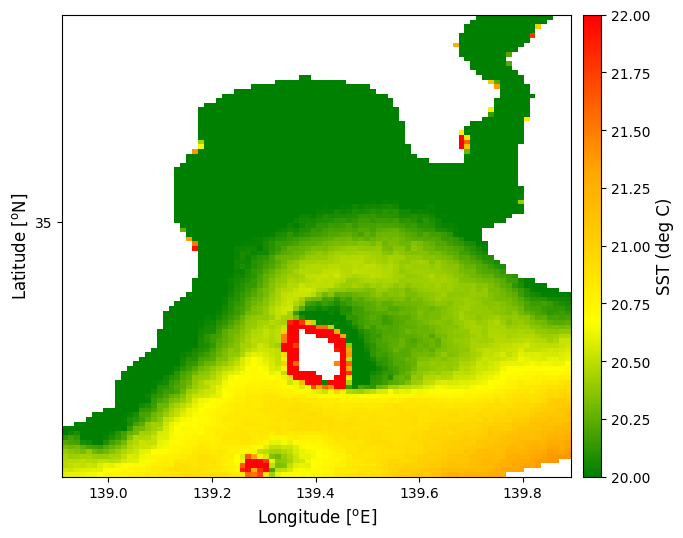

In [207]:

from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits import basemap
cmin, cmax = 20, 22
# Convert hex color list to RGB
rgb_colors = [ "green",  "yellow","orange","red"]
for season, sds_cropped in all_average.items():
    # Visualisation with basemap
    if len(lon_cropped.shape) == 1:
        lon_cropped, lat_cropped = np.meshgrid(lon_cropped, lat_cropped)
    lon_0, lat_0 = (lon_cropped.min() + lon_cropped.max()), (lat_cropped.min() + lat_cropped.max()) / 2
    m = basemap.Basemap(llcrnrlon=lon_cropped.min(), llcrnrlat=lat_cropped.min(), 
                        urcrnrlon=lon_cropped.max(), urcrnrlat=lat_cropped.max(), resolution='i', 
                        lon_0=lon_0, lat_0=lat_0, projection='merc')
    
    
    # Visualisation without basemap
    # Adjust figsize to change the aspect ratio
    fig, ax = plot.subplots(figsize=(8, 6))  # Adjust the width and height to better suit your data aspect ratio
    
    # figure bounds
    extent = [lon_cropped.min(), lon_cropped.max(), lat_cropped.min(), lat_cropped.max()]
    
    # Land mask
    # mask = np.where(~sds_cropped.mask, np.nan, 0)
    # ax.imshow(mask, cmap='gray', vmin=-2, vmax=0, extent=extent)
    
    # Create a colormap object
    custom_colormap = LinearSegmentedColormap.from_list('custom', rgb_colors)
    
    # Data 
    # We no longer use LogNorm here since we've manually applied log10
    # ims = ax.imshow(sds_cropped, cmap='jet', extent=extent)
    ims = ax.imshow(sds_cropped,vmin=cmin, vmax=cmax,  cmap=custom_colormap, extent=extent)
    
    # # Figure labels
    ax.set_xlabel('Longitude [$^\mathregular{o}$E]', fontsize="12")
    ax.set_ylabel('Latitude [$^\mathregular{o}$N]', fontsize="12")
    ax.set_yticks(range(int(np.ceil(lat_cropped.min())), int(np.ceil(lat_cropped.max())) + 1, 5))
    # ax.set_title(time[0].strftime('%b %Y'))
    
    # # Colourbar
    cbar = fig.colorbar(ims, ax=ax, orientation='vertical', fraction=0.0324, pad=0.02, aspect=26)
    # cbar.set_label('log10(Chl-a) Conc. mg/m^3', fontsize="12")
    cbar.set_label('SST (deg C)', fontsize="12")
    
    # # colourbar with axes set to match figure size
    # cax = plot.axes([0.8, 0.1, 0.03, 0.7]) # setup colorbar axes
    # cb = plot.colorbar(pm, label=label, cax=cax, format='%g') # draw colorbar
    # cb.ax.tick_params(width=2, length=4)
    # save


{'all': array([[      nan,       nan,       nan, ..., 19.618734, 21.433247,
        22.95064 ],
       [      nan,       nan,       nan, ..., 19.929695, 20.775414,
        23.018976],
       [      nan,       nan,       nan, ..., 21.133636, 21.891924,
        23.980452],
       ...,
       [20.480564, 20.506144, 20.521584, ..., 21.411386, 21.439194,
        21.44804 ],
       [20.55444 , 20.532047, 20.563074, ..., 21.440037, 21.441177,
        21.448114],
       [20.595903, 20.61684 , 20.605982, ..., 21.455057, 21.430166,
        21.457666]], dtype=float32)}


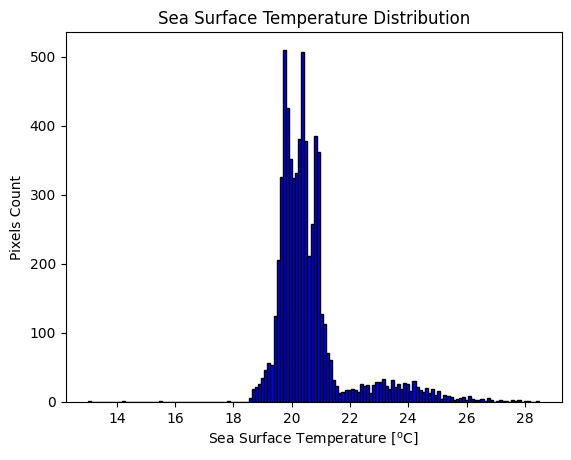

In [7]:
for season, sds_cropped in all_average.items():   
    fig, ax = plt.subplots()
    n_bins = 'auto'
    print(all_average)
    # mask all_average with 0
    pixel_values = sds_cropped.flatten()
    # pixel_values = pixel_values[~pixel_values.mask]  # Remove masked values (NaN or inf values)
    
    # ax.hist(sds_cropped_log.compressed(), bins=100, color='blue', alpha=0.7)
    ax.hist(pixel_values, bins=n_bins, color='blue', edgecolor='black')
    
    ax.set_xlabel('Sea Surface Temperature [$^\mathregular{o}$C]')
    ax.set_ylabel('Pixels Count')
    ax.set_title('Sea Surface Temperature Distribution')
    plt.savefig(f'seasonal/final/GCOMC-average_sst_{season:02}_hist.png', dpi=300)

    plt.show()

In [311]:
# Show data distribution in histogram for last month
for season, sds_cropped in all_average.items():    # Visualization with basemap
    fig, ax = plt.subplots()
    n_bins = 'auto'
    print(all_average)
    
    # Flatten the array to get pixel values for histogram
    pixel_values = sds_cropped.flatten()
    # If necessary, uncomment to remove masked values: pixel_values = pixel_values[~pixel_values.mask]
    
    # Histogram plotting
    counts, bins, patches = ax.hist(pixel_values, bins=n_bins, color='blue', edgecolor='black', alpha=0.7)
    
    # Sea surface temperature labeling
    ax.set_xlabel('SST (℃)')
    ax.set_ylabel('Pixels Count')
    ax.set_title(f'Mean SST Distribution')
    
    # Find min and max values from the bins since they determine the histogram's range
    min_val = bins[0]
    max_val = bins[-1]
    plt.xlim(15, 25)
    # # Annotate the histogram with min and max values
    # ax.annotate(f'Min: {min_val:.2f} $^\mathregular{o}$C', xy=(min_val, 0), xytext=(min_val, max(counts) * 0.1),
    #             arrowprops=dict(facecolor='green', shrink=0.05),
    #             )
    # ax.annotate(f'Max: {max_val:.2f} $^\mathregular{o}$C', xy=(max_val, 0), xytext=(max_val, max(counts) * 0.1),
    #             arrowprops=dict(facecolor='red', shrink=0.05),
    #             )
    
    # Save and show the figure
    plt.savefig(f'seasonal/final/MODIS-average_sst_{season:02}_hist.png', dpi=300, bbox_inches='tight')
    plt.show()


{'all': array([[      nan,       nan,       nan, ..., 19.618734, 21.433247,
        22.95064 ],
       [      nan,       nan,       nan, ..., 19.929695, 20.775414,
        23.018976],
       [      nan,       nan,       nan, ..., 21.133636, 21.891924,
        23.980452],
       ...,
       [20.480564, 20.506144, 20.521584, ..., 21.411386, 21.439194,
        21.44804 ],
       [20.55444 , 20.532047, 20.563074, ..., 21.440037, 21.441177,
        21.448114],
       [20.595903, 20.61684 , 20.605982, ..., 21.455057, 21.430166,
        21.457666]], dtype=float32)}


ConversionError: Failed to convert value(s) to axis units: 't'

Error in callback <function _draw_all_if_interactive at 0x000001E2E335B060> (for post_execute), with arguments args (),kwargs {}:


ConversionError: Failed to convert value(s) to axis units: 't'

ConversionError: Failed to convert value(s) to axis units: 't'

<Figure size 640x480 with 1 Axes>